20:00:12 - cmdstanpy - INFO - Chain [1] start processing
20:00:13 - cmdstanpy - INFO - Chain [1] done processing


MSE for sine wave prediction with custom seasonality (Daily): 0.0000


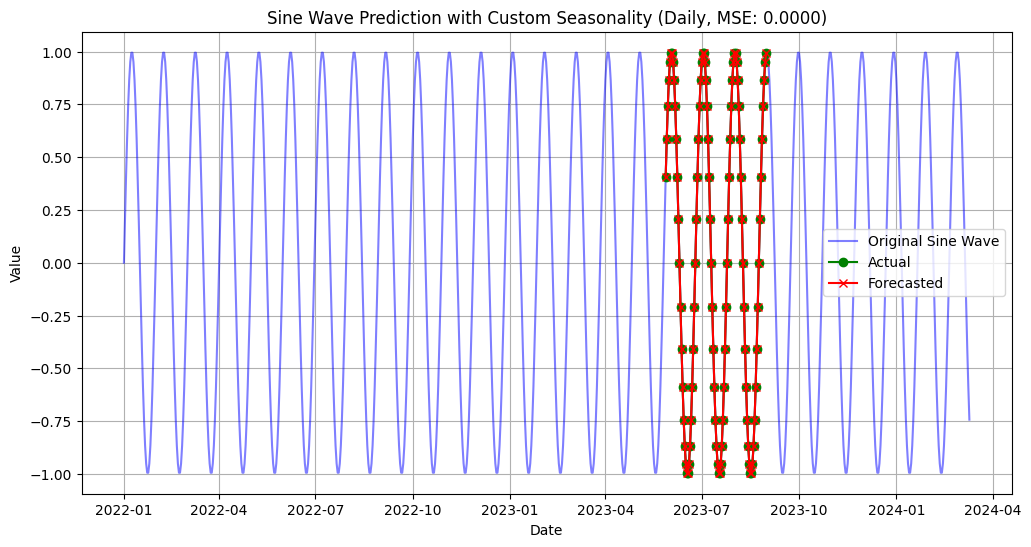

In [12]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Generate a random sine wave
np.random.seed(42)  # For reproducibility
x = np.arange(0, 800, 1)  # 800 points
amplitude = 1
frequency = 1 / 30  # Sine wave frequency (one cycle every 30 days)
noise = np.random.normal(0, 0.1, len(x))
y = amplitude * np.sin(2 * np.pi * frequency * x)  # Generate sine wave

# Calculate the period of the sine wave in days
sine_period_days = 1 / frequency  # Period = 1 / frequency (in days)

# Create a DataFrame with daily timestamps
start_date = pd.Timestamp('2022-01-01')
timestamps = pd.date_range(start=start_date, periods=len(y), freq='D')  # Daily frequency
data = pd.DataFrame({'ds': timestamps, 'y': y})

# Define context and prediction window
C = 512  # Context window (training size)
L = 96   # Prediction window (forecasting size)

# Split the data into training and testing
df_train = data.iloc[:C]  # First 512 points for training
df_test = data.iloc[C:C+L]  # Next 96 points for testing

# Initialize the Prophet model with no default seasonalities
model = Prophet(
    yearly_seasonality=False,  # Disable yearly seasonality
    weekly_seasonality=False,  # Disable weekly seasonality
    daily_seasonality=False,   # Disable daily seasonality
    changepoint_prior_scale=0.05  # Reduce trend flexibility
)

# Add custom seasonality for the sine wave
model.add_seasonality(name='sine_wave', period=sine_period_days, fourier_order=15)

# Fit the model on the sine wave data
model.fit(df_train)

# Create a future dataframe for prediction
future = pd.DataFrame({
    'ds': pd.date_range(df_train['ds'].iloc[-1] + pd.Timedelta(days=1), periods=L, freq='D')
})

# Predict future values
forecast = model.predict(future)

# Evaluate the forecast: merge actual vs predicted for the test set
result = pd.merge(df_test, forecast[['ds', 'yhat']], on='ds')
mse = mean_squared_error(result['y'], result['yhat'])
print(f"MSE for sine wave prediction with custom seasonality (Daily): {mse:.4f}")

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['y'], label='Original Sine Wave', color='blue', alpha=0.5)
plt.plot(result['ds'], result['y'], label='Actual', marker='o', color='green')
plt.plot(result['ds'], result['yhat'], label='Forecasted', marker='x', color='red')
plt.title(f"Sine Wave Prediction with Custom Seasonality (Daily, MSE: {mse:.4f})")
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
